In [1]:
import os
#import sys
#sys.path.append('../../notebooks/')
from modulos.sensormtx import *
import modulos.iluminacion_osrad as ill
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from dateutil.parser import parse
# mpl.rcParams['path.simplify'] = True
# mpl.rcParams['path.simplify_threshold'] = 0.5  # 0–1 aprox.; prueba 0.1–0.6
# import pyarrow.parquet as pq


In [2]:
# Posición de sensores:
#A10 = sensormtx(24.24,31.64,0,4.316,40,70,10.0)
#A102 = sensormtx(40.24,47.64,0,4.316,40,70,10.0)
#A20 = sensormtx(40.24,31.64,6.465,12.13,70,60,10.0)
#A202 = sensormtx(40.24,47.64,6.465,12.13,70,60,10.0)
# a40 = sensormtx(24.30,31.70,2.535,12.13,120,100,5.45)
# a40 = ill.daylight("../resultados/iluminancia/A40-1_anual.ill",a40)
# f = "../resultados/iluminancia/A40-1_anual.ill"
# ill_a40 = np.loadtxt(f,skiprows=10).reshape(100,120,365,24).transpose(2,3,0,1)
#A402 = sensormtx(24.30,31.70,2.535,12.13,120,100,5.45)
# rutas de resultados: '../resultados/{AULA}_anual.ill'
# AULA -> A10-1, A10-2, A20-1, A20-2, A40-1, A40-2

In [3]:
# a40 = sensormtx(24.30,31.70,2.535,12.13,120,100,5.45)
# a40 = ill.daylight("../resultados/iluminancia/A40-1_anual.ill",a40)
f = "../resultados/iluminancia/A40-1_anual.ill"
a401 = np.loadtxt(f,skiprows=10).reshape(100,120,366,24).transpose(2,3,0,1)


In [4]:
# a40_2 = sensormtx(24.30,31.70,2.535,12.13,120,100,5.45)
# a40 = ill.daylight("../resultados/iluminancia/A40-2_anual.ill",a40)
f = "../resultados/iluminancia/A40-2_anual.ill"
a402 = np.loadtxt(f,skiprows=10).reshape(100,120,366,24).transpose(2,3,0,1)

In [5]:
def grafica_mapa(ill,fecha='2024-06-26',hora=8,vmax=None):

    f1 = parse("2024-06-26")
    f1 = pd.to_datetime(f1)
    day = f1.dayofyear
    
    mapa = ill[day,hora].T[::1,::-1]
    
    fig, ax = plt.subplots()
    
    hour = 11
    nx = 100
    ny = 120
    dx, dy = 0.09595, 0.061666666666666654   # espaciamientos en X y Y
    x0, y0 = 0.0, 0.0
    x = x0 + np.arange(nx) * dx
    y = y0 + np.arange(ny) * dy
    X, Y = np.meshgrid(x, y)
    niveles = [0, 299, 500, 1000, 1500, 2000, 3000,4000,5000,6000,7000,8000,10000]
    
    contour_filled = ax.contourf(X,Y,mapa,levels=niveles,cmap="jet",alpha=0.7,vmax=vmax)
    contour = ax.contour(X, Y, mapa, colors='black', levels=niveles)
    ax.clabel(contour, inline=True, fontsize=8)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Definir la posición de la barra de color
    fig.colorbar(contour_filled, cax=cbar_ax, label='Iluminancia [lx]')


In [6]:

def regrid_mean_by_bins(Z, x, y, nx_out=20, ny_out=20, dx=None, dy=None):
    """
    Promedia Z (ny x nx) a una malla coarse (ny_out x nx_out) usando bins en X,Y.
    x,y son los centros de celda originales (longitudes nx y ny). Devuelve:
    Zc (ny_out x nx_out), Xc, Yc (centros coarse), edges_x, edges_y.
    """
    ny, nx = Z.shape
    if dx is None:
        dx = np.median(np.diff(x)) if len(x) > 1 else 1.0
    if dy is None:
        dy = np.median(np.diff(y)) if len(y) > 1 else 1.0

    # Bordes (usamos centros ± medio paso)
    x_edges = np.linspace(x[0] - dx/2, x[-1] + dx/2, nx_out + 1)
    y_edges = np.linspace(y[0] - dy/2, y[-1] + dy/2, ny_out + 1)
    x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
    y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])

    # Mallas originales (centros)
    X, Y = np.meshgrid(x, y)

    # A qué bin pertenece cada punto
    ix = np.digitize(X.ravel(), x_edges) - 1
    iy = np.digitize(Y.ravel(), y_edges) - 1

    # Máscara válida y sin NaN
    Zr = Z.ravel()
    mask = (
        (ix >= 0) & (ix < nx_out) &
        (iy >= 0) & (iy < ny_out) &
        ~np.isnan(Zr)
    )
    ixv = ix[mask]
    iyv = iy[mask]
    idx = iyv * nx_out + ixv  # índice lineal por celda

    # Acumula suma y cuenta por celda
    sums = np.bincount(idx, weights=Zr[mask], minlength=nx_out * ny_out)
    cnts = np.bincount(idx, minlength=nx_out * ny_out)

    Zc = np.full(nx_out * ny_out, np.nan, dtype=float)
    valid = cnts > 0
    Zc[valid] = sums[valid] / cnts[valid]
    Zc = Zc.reshape(ny_out, nx_out)

    Xc, Yc = np.meshgrid(x_centers, y_centers)
    return Zc, Xc, Yc, x_edges, y_edges

def grafica_mapa_promediado(ill, fecha='2024-06-26', hora=8, vmax=None,
                 nx=100, ny=120, dx=0.09595, dy=0.061666666666666654,
                 coarse=(9, 7)):
    # --- selecciona el mapa (y respeta tu orientación) ---
    day = pd.to_datetime(fecha).dayofyear
    mapa = ill[day, hora].T[:, ::-1]     # (ny x nx)

    # --- coordenadas originales (centros) ---
    x0, y0 = 0.0, 0.0
    x = x0 + np.arange(nx) * dx
    y = y0 + np.arange(ny) * dy

    # --- regrid a 10x7 por promedio en bins ---
    nx_out, ny_out = coarse
    Zc, Xc, Yc, _, _ = regrid_mean_by_bins(mapa, x, y, nx_out=nx_out, ny_out=ny_out, dx=dx, dy=dy)

    # --- plot comparativo: original vs promediado ---
    niveles = [0, 299, 500, 1000, 1500, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 10000]
    fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

    # Original
    X, Y = np.meshgrid(x, y)
    cf1 = axs[0].contourf(X, Y, mapa, levels=niveles, cmap="jet", alpha=0.7, vmax=vmax)
    c1 = axs[0].contour(X, Y, mapa, colors='black', levels=niveles, linewidths=0.6)
    axs[0].clabel(c1, inline=True, fontsize=8)
    axs[0].set_title("Simulación 100×120")

    # Promediado (10×7)
    cf2 = axs[1].contourf(Xc, Yc, Zc, levels=niveles, cmap="jet", alpha=0.7, vmax=vmax)
    c2 = axs[1].contour(Xc, Yc, Zc, colors='black', levels=niveles, linewidths=0.6)
    axs[1].clabel(c2, inline=True, fontsize=8)
    axs[1].set_title(f"Promedio por bins {nx_out}×{ny_out}")

    # Barra de color única
    cbar = fig.colorbar(cf2, ax=axs, fraction=0.046, pad=0.04)
    cbar.set_label('Iluminancia [lx]')

    for ax in axs:
        ax.set_xlabel("[m]")
        ax.set_ylabel("[m]")

    return Zc, Xc, Yc


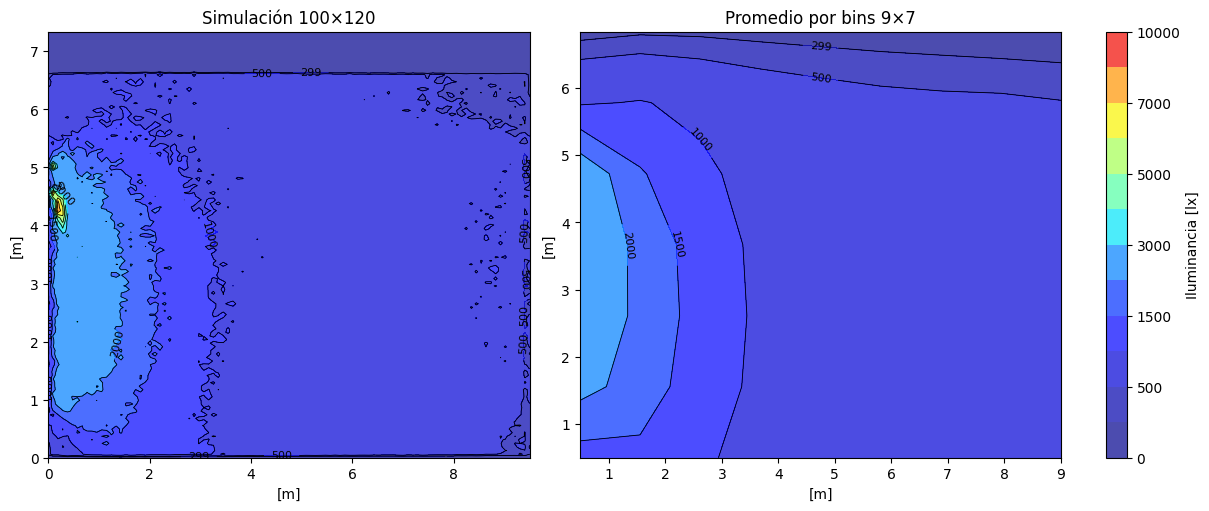

In [7]:
_,_,_ = grafica_mapa_promediado(a402,vmax=10_000,hora=10)